In [30]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [66]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [32]:
# Loading in horror author data
df = pd.read_csv("Data/spooky.csv", index_col = "id")
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [33]:
# Checking nulls and duplicates
df.info()
print(f'Duplicate count: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, id26305 to id00393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19579 non-null  object
 1   author  19579 non-null  object
dtypes: object(2)
memory usage: 458.9+ KB
Duplicate count: 0


# Data Preparation

In [34]:
# Let's make a feature for word sequence length
df['sequence_length'] = df['text'].map(lambda x: len(x.split(" ")))
df.head()

,text,author,sequence_length
id,,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP,41
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,14
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP,36
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS,34
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL,27


In [35]:
# Getting stats
df.describe()

,sequence_length
count,19579.000000
mean,26.730477
std,19.048353
min,2.000000
25%,15.000000
50%,23.000000
75%,34.000000
max,861.000000


### Typical passage length is ~27 words, though some span more than a page of text (over ~500)

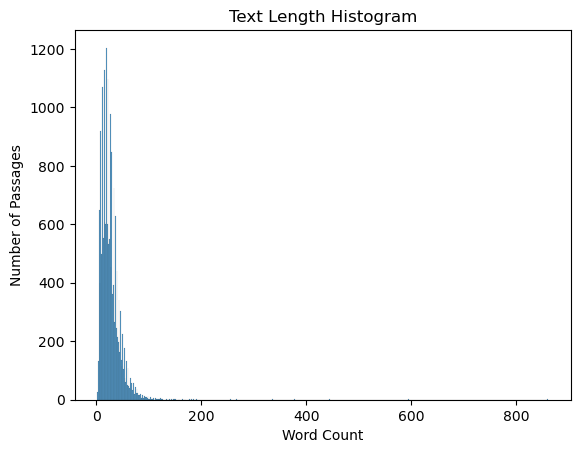

In [36]:
# Making histplot
ax = sns.histplot(data=df, x='sequence_length')
ax.set(title="Text Length Histogram", xlabel="Word Count", ylabel="Number of Passages");

In [37]:
# checking our target balance, maybe some authors are overrepresented.
df['author'].value_counts(normalize=True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

In [38]:
# We can use a random undersampler to balance
sampler = RandomUnderSampler(random_state=42)
df, _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts(normalize=True)

EAP    0.333333
HPL    0.333333
MWS    0.333333
Name: author, dtype: float64

In [46]:
# We need to transform our string values (author initials) into integers to vectorize
y_map = {"EAP":0, "HPL":1, "MWS":2}
y = df['author'].map(y_map)
y.unique()

array([0, 1, 2], dtype=int64)

In [45]:
# Naming X an array of text feature
X = df['text'].values
X

array(['He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.',
       'Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.',
       'The cold was intense, and obliged me to wrap up closely in an overcoat.',
       ...,
       'What I ask of you is reasonable and moderate; I demand a creature of another sex, but as hideous as myself; the gratification is small, but it is all that I can receive, and it shall content me.',
       'The birth of her daughter, embryo copy of her Raymond, filled up the measure of her content, and produced a sacred and indissoluble tie between them.',
       "I heard my sister's sobs, and thought, happy are women who can weep, and in a passionate caress disburthen the oppression of their feelings; shame and habitual restraint hold back a man."],
      dtype=object)

In [47]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [48]:
# shuffling the data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [50]:
# Determing how many samples for each split
split_train = 0.7
split_val = 0.2
split_test = 1 - (split_train + split_val)
# Calculate the number of samples for training 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) - (n_train_samples + n_val_samples)
# setting batch size
BATCH_SIZE = 32
# using math package with ceiling rounding to get batch numbers per sample group
import math
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
# Displaying sample and batch counts
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [51]:
# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skipover the training batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [52]:
# Confirming batch counts
print (f'Training: {len(train_ds)} batches.')
print (f'Validation: {len(val_ds)} batches.')
print (f'Testing: {len(test_ds)} batches.')

Training: 370 batches.
Validation: 106 batches.
Testing: 53 batches.


# Vectorization

In [53]:
# Making sequence vectorization layer
SEQ_LENGTH = 100
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int", output_sequence_length=SEQ_LENGTH)

In [54]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'And this was in truth the Death of which these bystanders spoke reverently, in low whispers you, sweet Una, gaspingly, with loud cries.',
       b'Had my eyes deceived me?',
       b"For some distance the line kept on along the gorge's brink, but at length I reached the long covered bridge where it crossed the chasm at a dizzy height.",
       b'The two forces mingling, unarmed and hand in hand, talking only how each might assist the other, the adversaries conjoined; each repenting, the one side their former cruelties, the other their late violence, they obeyed the orders of the General to proceed towards London.',
       b'I have already put off the carelessness of childhood, the unlined brow, and springy gait of early years, that they may adorn thee.',
       b'Idleness had ever been irksome to me, and now that I wished to fly from reflection, and hated my former studies, I felt great relief in being the fellow pupil with my frie

In [55]:
# Adapting to our training data
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

20976

In [56]:
# Defining vocabulary size
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [57]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'he',
 14: 'had',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'which',
 21: 'not',
 22: 'me',
 23: 'at',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'her',
 30: 'be',
 31: 'were',
 32: 'have',
 33: 'you',
 34: 'all',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'when',
 40: 'him',
 41: 'one',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'would',
 47: 'she',
 48: 'there',
 49: 'upon',
 50: 'more',
 51: 'its',
 52: 'their',
 53: 'now',
 54: 'what',
 55: 'some',
 56: 'our',
 57: 'into',
 58: 'if',
 59: 'them',
 60: 'who',
 61: 'are',
 62: 'will',
 63: 'than',
 64: 'then',
 65: 'only',
 66: 'very',
 67: 'up',
 68: 'before',
 69: 'man',
 70: 'about',
 71: 'even',
 72: 'these',
 73: 'out',
 74: 'yet',
 75: 'your',
 76: 'time',
 77: 'did',
 78: 'any',
 79: 'old',
 80: 'said',
 81: 'might',
 82: 'li

In [58]:
# Pulling specific word
int_to_str[1000]

'occasion'

In [59]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(["Text Vectorization is an essential tool for converting text into a format that machine learning models can use."])
sequence

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 6345,     1,    28,    35,  6996, 13401,    18,     1,  6345,
           57,     7,     1,    10,   833,  3862, 16160,   122,   521,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

# LSTM Model

In [ ]:
import custom_functions as fn

In [61]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str

In [63]:
# We can pull a custom function to make our vectorization layer
sequence_vectorizer, vocab_lookup = make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQ_LENGTH, verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_2',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 100,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 20976}
)


In [65]:
# Defining output dimension
EMBED_DIM = 150
EMBED_DIM

150

In [72]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQ_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(y.unique()), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [68]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
370/370 [==============================] - 38s 96ms/step - loss: 1.1023 - accuracy: 0.3342 - val_lo

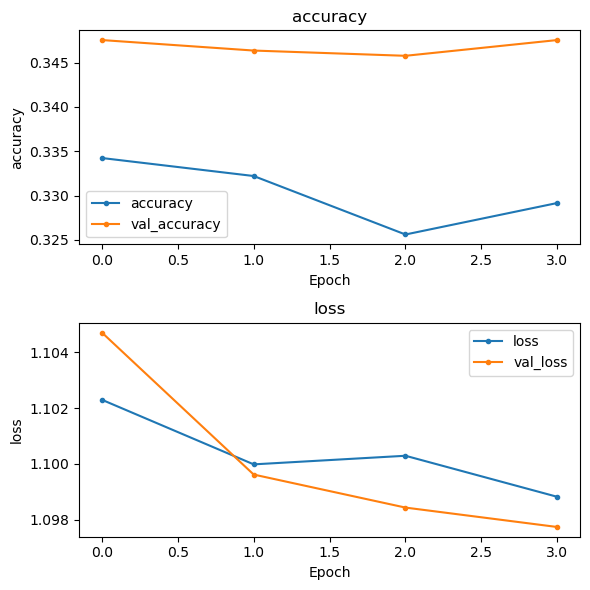


- Evaluating Network...


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      3906
           1       0.00      0.00      0.00      3952
           2       0.82      0.00      0.01      3975

    accuracy                           0.33     11833
   macro avg       0.38      0.33      0.17     11833
weighted avg       0.39      0.33      0.17     11833



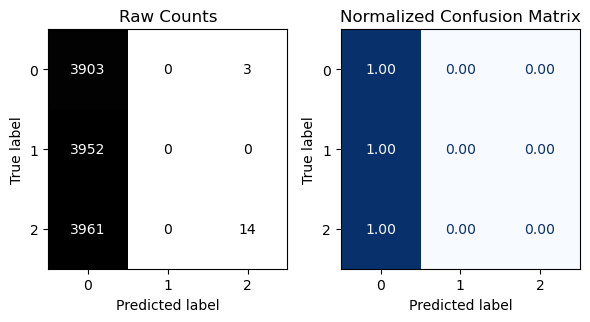


- Evaluating Training Data:
  4/370 [..............................] - ETA: 8s - loss: 1.1006 - accuracy: 0.2734 

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


370/370 [==============================] - 8s 22ms/step - loss: 1.0975 - accuracy: 0.3310
{'loss': 1.0975170135498047, 'accuracy': 0.3310233950614929}


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       559
           1       0.00      0.00      0.00       560
           2       0.50      0.00      0.00       572

    accuracy                           0.33      1691
   macro avg       0.28      0.33      0.17      1691
weighted avg       0.28      0.33      0.17      1691



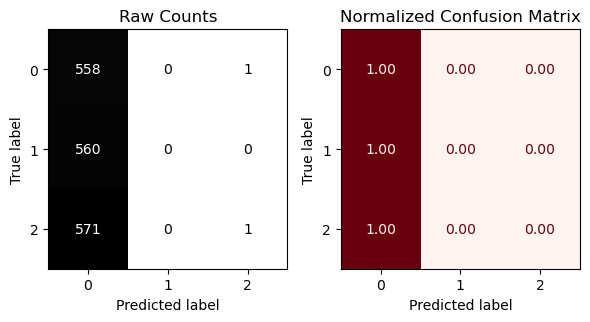


- Evaluating Test Data:
 7/53 [==>...........................] - ETA: 1s - loss: 1.0967 - accuracy: 0.3616

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53/53 [==============================] - 1s 21ms/step - loss: 1.0993 - accuracy: 0.3306
{'loss': 1.099254846572876, 'accuracy': 0.3305736184120178}


In [73]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 25
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

# GRU Model

In [74]:
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQ_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(y.unique()), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

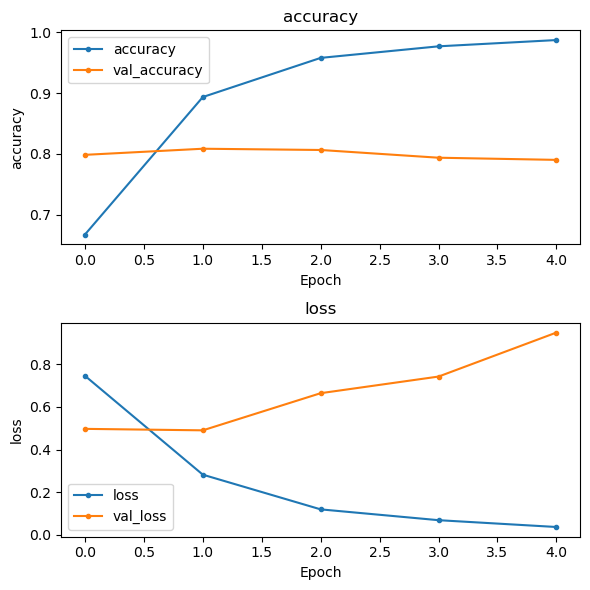


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3906
           1       0.99      1.00      0.99      3952
           2       1.00      0.99      0.99      3975

    accuracy                           0.99     11833
   macro avg       0.99      0.99      0.99     11833
weighted avg       0.99      0.99      0.99     11833



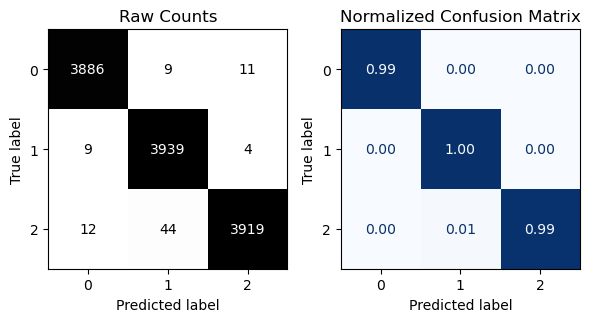


- Evaluating Training Data:
370/370 [==============================] - 7s 19ms/step - loss: 0.0235 - accuracy: 0.9925
{'loss': 0.02347148396074772, 'accuracy': 0.9924786686897278}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       559
           1       0.78      0.85      0.81       560
           2       0.85      0.80      0.82       572

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



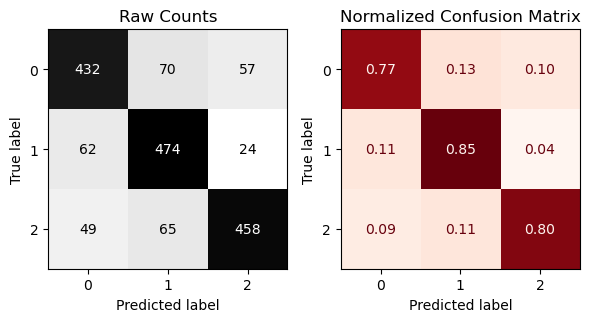


- Evaluating Test Data:
53/53 [==============================] - 1s 18ms/step - loss: 0.8829 - accuracy: 0.8066
{'loss': 0.8829173445701599, 'accuracy': 0.8066232800483704}


In [75]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

### The GRU Model is the clear strong model to use for predicting authorship of texts with testing accuracy ~80%. However, loss began to quickly rise after the second epoch.